# Parsing and Recombining Inputs

In the chapter on [Grammars](Grammars.ipynb), we discussed how grammars can be
used to represent various languages. We also saw how grammars can be used to
generate strings of the corresponding language. Grammars can also perform the
reverse. That is, given a string, one can decompose the string into its
constituent parts that correspond to the parts grammar used to generate it
-- the derivation tree of that string. These parts (and parts from other similar
strings) can later be recombined using the same grammar to produce new strings.

In this chapter, we use grammars to parse and decompose inputs to
their corresponding derivation trees, allowing us to recombine them
arbitrarily.

**Prerequisites**

* You should have read the [chapter on grammars](Grammars.ipynb).
* An understanding of derivation trees from the [chapter on grammar fuzzer](GrammarFuzzer.ipynb)
  is also required.

In [1]:
import fuzzingbook_utils
from Grammars import EXPR_GRAMMAR, START_SYMBOL, RE_NONTERMINAL
from GrammarFuzzer import display_tree, all_terminals, GrammarFuzzer
from ExpectError import ExpectError

In order to parse a string, one needs to identify the language, and the
corresponding grammar. For example, here is a string that we would like to parse

In [2]:
mystring = '1+2'

This string is an arithmetic expression for addition, which may be specified using a grammar.

In [3]:
A1_GRAMMAR = {
   "<start>":
       ["<expr>"],
   "<expr>":
       ["<expr>+<expr>", "<expr>-<expr>", "<integer>"],
   "<integer>":
       ["<digit><integer>", "<digit>"],
   "<digit>":
        ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

The parse tree for our expression from this grammar is given by:

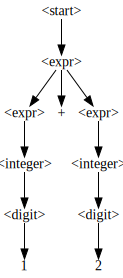

In [4]:
tree = ('<start>',[
    ('<expr>',[
        ('<expr>',[('<integer>',[('<digit>',[('1',[])])])]),
        ('+',[]),                           
        ('<expr>',[('<integer>',[('<digit>',[('2',[])])])])])])
assert mystring == all_terminals(tree)
display_tree(tree)

While a grammar can be used to specify a given language, there could be multiple
grammars that correspond to the same language. For example, here is another 
grammar to describe the same addition expression.

In [5]:
A2_GRAMMAR = {
   "<start>":
      ["<expr>"],
   "<expr>":
      ["<integer><expr_>"],
   "<expr_>":
      ["+<expr>", "-<expr>", ""],
   "<integer>":
      ["<digit><integer_>"],
   "<integer_>":
      ["<integer>", ""],
   "<digit>":
      ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
}

The corresponding derivation tree is given by:

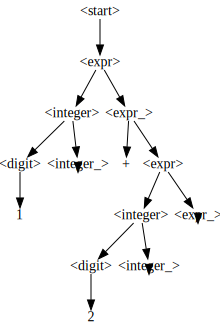

In [6]:
tree = ('<start>', [
    ('<expr>', [('<integer>',
                 [('<digit>', [('1', [])]), ('<integer_>', [('',[])])]),
                ('<expr_>', [('+', []), 
                             ('<expr>', [
                                 ('<integer>', [
                                     ('<digit>', [('2', [])]),
                                     ('<integer_>', [('',[])])]),
                                 ('<expr_>', [('',[])])])])])])
assert mystring == all_terminals(tree)
display_tree(tree)

Indeed, there could be different classes of grammars that
describe the same language. For example, the first grammar `A1_GRAMMAR`
is a grammar that sports both _right_ and _left_ recursion, while the
second grammar `A2_GRAMMAR` does not have left recursion in the
non-terminals in any of its productions, but contains _epsilon_ productions.
(An epsilon production is a production that has empty string in its right
hand side.)

A grammar is left recursive if any of its non-terminals are left recursive,
and a non-terminal is directly left-recursive if the left-most symbol of
any of its productions is itself. It is indirectly left-recursive if any
of the left-most symbols can be expanded using their definitions to
produce the non-terminal as the left-most symbol of the expansion.
Right recursive grammars are defined similarly.

For example, in `A1_GRAMMAR`, the definition of `<expr>` is
left-recursive, and right recursive directly. However in `A2_GRAMMAR`,
`<expr>` is right recursive indirectly through the expansion of `<expr_>`.

To complicate matters further, there could be
multiple derivation trees -- also called _parses_ -- corresponding to the
same string from the same grammar. For example, a string `1+2+3` can be parsed
in two ways as we see below using the `A1_GRAMMAR`

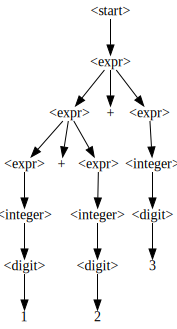

In [7]:
mystring = '1+2+3'
tree = ('<start>', [
    ('<expr>', [
        ('<expr>', [
            ('<expr>', [('<integer>', [('<digit>', [('1', [])])])]),
            ('+', []),
            ('<expr>', [('<integer>', [('<digit>', [('2', [])])])])]), 
        ('+', []), 
        ('<expr>', [('<integer>', [('<digit>', [('3', [])])])])])])
assert mystring == all_terminals(tree)
display_tree(tree)

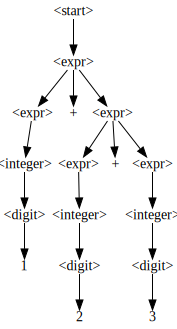

In [8]:
tree = ('<start>', [
    ('<expr>', [
        ('<expr>', [('<integer>', [('<digit>', [('1', [])])])]), 
        ('+', []), 
        ('<expr>', [
            ('<expr>', [('<integer>', [('<digit>', [('2', [])])])]), 
            ('+', []), 
            ('<expr>', [('<integer>', [('<digit>', [('3', [])])])])]) ])])
assert all_terminals(tree) == mystring
display_tree(tree)

Numerous parsing techniques exist that can take a grammar and the given
string, and produce the corresponding derivation tree or trees. However,
some of these techniques work only on specific classes of grammars.
These classes of grammars are named after the specific kind of parser
that can accept grammars of that category. That is, the upper bound for
the capabilities of the parser defines the grammar class named after that
parser.

Different classes of grammars differ in the features that are available to
the user for writing a grammar of that class. That is, the corresponding
kind of parser will be unable to parse a grammar that makes use of more
features than is allowed. For example, the `A2_GRAMMAR` is an _LL(1)_
grammar because it lacks left recursion, while `A1_GRAMMAR` is not an
_LL(1)_ grammar. This is because an _LL_ parser is a parser that parses
its input from left to right, and constructs a leftmost derivation of its
input by expanding the non-terminals it encounters. If there is a left
recursion in one of these rules, an _LL_ parser will enter an infinite loop.

We will examine a few classes of parsers next. First we define a few common
features required by all parsers we implement.

In [9]:
from functools import reduce, lru_cache
import re

The  `EXPR_GRAMMAR` we import from the [chapter on grammars](Grammars.ipynb) is oriented towards generation. In particular, the production rules are stored as strings. We need to massage this representation a little to conform to a canonical representation where each token in a rule is represented separately.

In [10]:
def split(rule):
    return [token
            for token in re.split(RE_NONTERMINAL, rule)
            if token]

def canonical(grammar):
    return  {key: [split(choice) for choice in choices]
             for key, choices in grammar.items()}

We define a minimal interface for parsing, that is obeyed by all parsers.

In [11]:
class Parser(object):
    def __init__(self, grammar, start_symbol=START_SYMBOL):
        self.start_symbol = start_symbol
        self.grammar = grammar
        
    def parse_prefix(self, text):
        """Return pair (cursor, forest) for longest prefix of text"""
        raise NotImplemented()
        
    def parse(self, text):
        cursor, forest = self.parse_prefix(text)
        if cursor < len(text):
            raise SyntaxError("at " + repr(text[cursor:]))
        return forest

## Parsing Expression Grammars

Short of hand rolling a parser, _Packrat_ parsing is one of the simplest parsing techniques, and the class of grammar it accepts is called a _Parsing Expression Grammar_ (_Packrat_ is one of the techniques for parsing PEGs).

A _Parsing Expression Grammar_ comes is very similar to a _Context Free Grammar_. As in a _Context Free Grammar_, the grammar is represented by a set of non-terminals and corresponding **choice expressions** representing how to match each. For example, here is a PEG that matches `a` or `b`.

In [12]:
peg = {
    '<start>': [['a'],['b']]
}

However, unlike the _CFG_, the choice expression is an **ordered choice**. That is, rather than choosing all rules that can potentially match, we stop at the first match that succeed. For example, the below _PEG_ can match `ab` but not `abc` unlike a _CFG_ which will match both.

In [13]:
peg = {
    '<start>': [['ab'],['abc']]
}

Each choice in a _choice expression_ represents a rule on how to satisfy that particular choice. The choice is a sequence of tokens (terminals and non-terminals) that are matched against a given text as in a _CFG_.

Beyond the syntax of grammar definitions we have seen so far, a _PEG_ can can also contain a few additional elements. See the exercises at the end of the chapter for additional information.

The parsing expression grammars model the typical practice in handwritten recursive descent parsers, and hence it may be considered more intuitive to understand. Further, it comes with attractive properties such as linear time parsing (the time required to parse increases linearly with the increase in input length).

We look at the implementation of a simple PEG parser next.

### Packrat Parser for _PEGs_

We derive from the `Parser` base class first, and we accept the text to be parsed in the `parse` method, which in turn calls `unify_key` with the `start_symbol` which is the starting point of parsing.

In [14]:
class PEGParser(Parser):
    def __init__(self, grammar, start_symbol):
        super().__init__(canonical(grammar), start_symbol)
        
    def parse_prefix(self, text):
        return self.unify_key(self.start_symbol, text, 0)

The `unify_key` algorithm is simple. If given a terminal symbol, it tries to match the symbol with the current position in the text. If the symbol and text match, it returns successfully with the new parse index `at`.

If on the other hand, it was given a non-terminal, it retrieves the choice expression corresponding to the key, and tries to match each choice in order using `unify_rule`. If **any** of the rules succeed in being unified with the given text, the parse is considered a success, and we return with the new parse index returned by `unify_rule`.

In [15]:
class PEGParser(PEGParser):
    def unify_key(self, key, text, at=0):
        if key not in self.grammar:
            if text[at:].startswith(key): return at + len(key), (key, [])
            else: return at, None
        for rule in self.grammar[key]:
            to, res = self.unify_rule(rule, text, at)
            if res: return (to, (key, res))
        return 0, None

The `unify_rule` is similar. It retrieves the tokens corresponding to the rule that it needs to unify with the text, and calls `unify_key` on them in sequence. If **all** tokens are successfully unified with the text, the parse is a success.

In [16]:
class PEGParser(PEGParser):
    def unify_rule(self, rule, text, at):
        results = []
        for token in rule:
            at, res = self.unify_key(token, text, at)
            if res is None: return at, None
            results.append(res)
        return at, results

The two methods are mutually recursive, and given that `unify_key` tries each alternative until it succeeds, `unify_key` can be called multiple times with the same arguments. Hence, it is import to memoize the results of `unify_key`. Python provides a simple decorator that is available at `functools.lru_cache` for memoizing any function call that has hashable arguments. We add that to our implementation so that repeated calls to `unify_key` with same arguments get cached results.

This memoization gives the algorithm its name -- _Packrat_.

In [17]:
class PEGParser(PEGParser):
    @lru_cache(maxsize=None)
    def unify_key(self, key, text, at=0):
        if key not in self.grammar:
            if text[at:].startswith(key): return at + len(key), (key, [])
            else: return at, None
        for rule in self.grammar[key]:
            to, res = self.unify_rule(rule, text, at)
            if res: return (to, (key, res))
        return 0, None

We wrap initialization and calling of `PEGParser` in a method `parse` that accepts the text to be parsed along with the grammar.

In [18]:
def parse(text, grammar):
    peg = PEGParser(grammar, START_SYMBOL)
    return peg.parse(text)  

Here are a few examples of our parser in action.

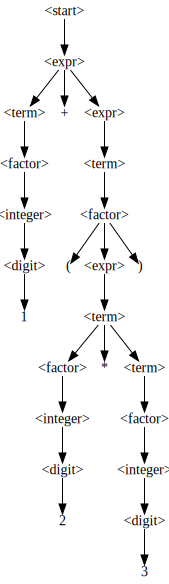

In [19]:
mystring = "1 + (2 * 3)"
tree = parse(mystring, EXPR_GRAMMAR)
assert all_terminals(tree) == mystring
display_tree(tree)

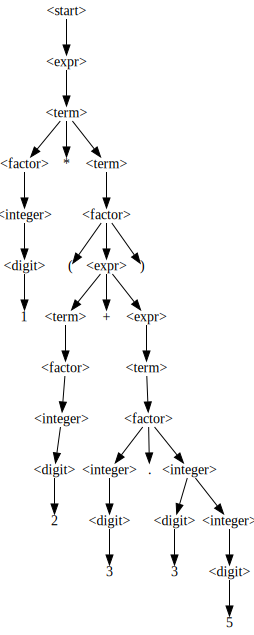

In [20]:
mystring = "1 * (2 + 3.35)"
tree = parse(mystring, EXPR_GRAMMAR)
assert all_terminals(tree) == mystring
display_tree(tree)

One should be aware that while the grammar looks like a _Context Free Grammar_, the language described by a PEG may be different (only _LL(1)_ grammars are guaranteed to represent the same language for both PEGs and other parsers), while other behaviors could be surprising~\cite{redziejowski2008}. 

While _Parsing Expression Grammars_ are simple at first sight, their behavior in some cases might be a bit unintuitive. For example, here is an example from Redziejowski~\cite{redziejowski}

In [21]:
PEG_SURPRISE = {
    "<A>": ["a<A>a","aa"]
}

When interpreted as a context free grammar and used as a string generator, it will produce strings of the form `a, aa, aaaa, aaaaaa` that is, it produces strings where the number of `a` is \Latex{2*n}.

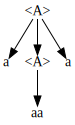

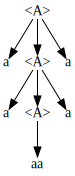

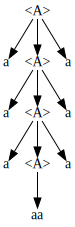

['aa', 'aaaa', 'aaaaaa', 'aaaaaaaa']

In [22]:
strings = []
for e in range(4):
    f = GrammarFuzzer(PEG_SURPRISE, '<A>')
    tree = ('<A>',None)
    for _ in range(e):
        tree = f.expand_tree_once(tree)
    tree = f.expand_tree_with_strategy(tree, f.expand_node_min_cost)
    strings.append(all_terminals(tree))
    display_tree(tree)
strings

aa


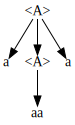

aaaa


Traceback (most recent call last):
  File "<ipython-input-23-6bc1849ba802>", line 4, in <module>
    tree = peg.parse(s)
  File "<ipython-input-11-ab6c0003a2e2>", line 13, in parse
    raise SyntaxError("at " + repr(text[cursor:]))
  File "<string>", line None
SyntaxError: at 'aa' (expected)


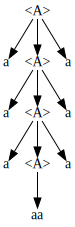

aaaaaaaa


In [23]:
peg = PEGParser(PEG_SURPRISE, '<A>')
for s in strings:
    with ExpectError():
        tree = peg.parse(s)
        display_tree(tree)
        print(s)

## Context Free Grammars

While the _Parsing Expression Grammars_ are expressive and the _packrat_ parser for parsing them is simple and intuitive, PEGs suffer from a major deficiency for our purposes. PEGs are oriented towards language recognition, and it is not clear how to translate an arbitrary PEG to a _CFG_. As we mentioned earlier, a naive re-interpretation of a PEG as a CFG does not work very well. Further, it is not clear what is the exact relation between the class of languages represented by _PEG_ and the the class of languages represented by _CFG_. Since our primary focus is _fuzzing_ -- that is _generation_ of strings, we next look at parsers that can accept _CFG_.

We require meta characters for marking an empty string, and for marking the end of input.

In [24]:
EOF = '\0'
EPSILON = ''

The `rules` method takes in a grammar and returns `(key,production)` pairs for each production in the grammar. This is an alternative representation of a grammar.

In [25]:
def rules(grammar):
    return [(key, choice)
            for key, choices in grammar.items()
            for choice in choices]

In [26]:
rules(canonical(EXPR_GRAMMAR))

[('<start>', ['<expr>']),
 ('<expr>', ['<term>', ' + ', '<expr>']),
 ('<expr>', ['<term>', ' - ', '<expr>']),
 ('<expr>', ['<term>']),
 ('<term>', ['<factor>', ' * ', '<term>']),
 ('<term>', ['<factor>', ' / ', '<term>']),
 ('<term>', ['<factor>']),
 ('<factor>', ['+', '<factor>']),
 ('<factor>', ['-', '<factor>']),
 ('<factor>', ['(', '<expr>', ')']),
 ('<factor>', ['<integer>', '.', '<integer>']),
 ('<factor>', ['<integer>']),
 ('<integer>', ['<digit>', '<integer>']),
 ('<integer>', ['<digit>']),
 ('<digit>', ['0']),
 ('<digit>', ['1']),
 ('<digit>', ['2']),
 ('<digit>', ['3']),
 ('<digit>', ['4']),
 ('<digit>', ['5']),
 ('<digit>', ['6']),
 ('<digit>', ['7']),
 ('<digit>', ['8']),
 ('<digit>', ['9'])]

The `terminals` method extracts all terminal symbols from a `canonical` grammar representation.

In [27]:
def terminals(grammar):
    return set(token
               for key, choice in rules(grammar)
               for token in choice if token not in grammar)

In [28]:
terminals(canonical(EXPR_GRAMMAR))

{' * ',
 ' + ',
 ' - ',
 ' / ',
 '(',
 ')',
 '+',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9'}

While parsing, one often requires to know whether a given non-terminal can derive an empty string. For example, in the following grammar, the rule for `A` can derive an empty string, while the rule for `B` can't. The non-terminals that can derive an empty string is called a `nullable` non-terminal, and the set of all such non-terminals is called a `nullable` set.

In [29]:
my_grammar = {
    '<start>': [['<A>'], ['<B>']],
    '<A>': [['a'],['']],
    '<B>': [['b']]
}

Computing the `nullable` set requires expanding each production rule in the grammar iteratively and inspecting whether a given rule can derive the empty string. Each iteration needs to take into account new terminals that have been found to be nullable. The procedure stops when we obtain a stable result. This procedure can be abstracted into a more general method `fixpoint`. A `fixpoint` of a function is an element in the function's domain such that it is mapped to itself. For example, `1` is a `fixpoint` of `math.sqrt` because `math.sqrt(1.0) == 1.0`. 

(We use `str` rather than `hash` to check for equality in `fixpoint` because `set`, which we would like to use as an argument has a good string representation but is not hashable).

In [30]:
def fixpoint(f):
    def helper(arg):
        while True:
            sarg = str(arg)
            arg_ = f(arg)
            if str(arg_) == sarg:
                return arg
            arg = arg_
    return helper

Remember `my_sqrt` from the first chapter? We can define `my_sqrt` using `fixpoint`.

In [31]:
def my_sqrt(x):
    @fixpoint
    def _my_sqrt(approx):
        return (approx + x / approx) / 2
    return _my_sqrt(1)

In [32]:
my_sqrt(2)

1.414213562373095

Similarly, we can define `nullable` using `fixpoint`. We essentially provide the definition of a single intermediate step. That is, assuming that `nullables` contain the current nullable non-terminals, we iterate over the grammar looking for productions which are `nullable` -- that is, productions where the entire sequence can yield an empty string on some expansion.

In [33]:
def nullable(grammar):
    productions = rules(grammar)
    @fixpoint
    def nullable_(nullables):
        for A, expr in productions:
            if all(token in nullables for token in expr):
                nullables |= {A}
        return (nullables)
    return nullable_({EPSILON})

The nullable non-terminals in `my_grammar` is computed as expected (It includes EPSILON which is technically not a non-terminal, but you can ignore that for now).

In [34]:
nullable(my_grammar)

{'', '<A>', '<start>'}

 (**Advanced**: This `nullable` implementation, while simple, is not the best. See [Jeffrey Kegler](https://github.com/jeffreykegler/kollos/blob/master/notes/misc/loup2.md) for a faster implementation.)

We require an additional method to massage our `EXPR_GRAMMAR`. This method removes the extraneous spaces from the grammar definition. While the spaces are reasonable when one is generating strings, they make our parses needlessly complicated.

In [35]:
def shrink(rule):
    return [i.strip() for i in rule]

def canonical(grammar):
    return  {k: [shrink(split(l)) for l in rules]
             for k, rules in grammar.items()}

In [36]:
canonical(EXPR_GRAMMAR)

{'<start>': [['<expr>']],
 '<expr>': [['<term>', '+', '<expr>'], ['<term>', '-', '<expr>'], ['<term>']],
 '<term>': [['<factor>', '*', '<term>'],
  ['<factor>', '/', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

### Earley parser

The Earley parser is a general parser that is able to parse arbitrary _Context Free Grammars_. It was invented by Jay Earley~\cite{Earley1970} for use in computational linguistics. While its computational complexity is $O(n^3)$ for arbitrary grammars, it can parse unambiguous grammars in $O(n^2)$ time, and all _[LR(k)](https://en.wikipedia.org/wiki/LR_parser)_ grammars in linear time ($O(n)$~\cite{Leo1991}). Further improvements -- notably handling epsilon rules -- were invented by Aycock et al.~\cite{Aycock2002}.

Note that one restriction of our implementation is that the start symbol should have only one choice in its choice expression. This is not a restriction in practice because any grammar with multiple choices in its start symbol can be extended with a new start symbol that has the original start symbol as its only choice. That is, given a grammar as below to conform to the single choice rule:

```
grammar = {
    '<start>': [['<A>'], ['<B>']],
    '<A>': [['a'], ['A']],
    '<B>': [['b'], ['']],    
}
```
One may rewrite it as
```
grammar = {
    '<start>': [['<start_>']],
    '<start_>': [['<A>'], ['<B>']],
    '<A>': [['a'], ['A']],
    '<B>': [['b'], ['']],    
}
```

The parser uses dynamic programming to generate a table containing a forest of possible parses at each letter index -- the table contains as many columns as there are letters in the input, and each column contains different parsing rules at various stages of the parse.

#### Columns
We define the `Column` first. The `Column` is initialized by its own `index` in the input string, and the `letter` at that index. Internally, we also keep track of the states that are added to the column as the parsing progresses.

In [37]:
class Column(object):
    def __init__(self, index, letter):
        self.index, self.letter = index, letter
        self.states, self._unique =  [], {}

The `Column` only stores unique `states`. Hence, when a new `state` is `added` to our `Column`, we check whether it is already known.

In [38]:
class Column(Column):
    def add(self, state):
        if state in self._unique: return self._unique[state]
        self._unique[state] = state
        self.states.append(state)
        return self._unique[state]

#### States

A `State` represents a parse in progress for a specific rule corresponding to a non-terminal. Hence, the state contains the `name` of the non-terminal, the corresponding choice expression (`expr`), and the current position of parsing in this expression (`dot`). We further store the starting column `s_col` and ending column `e_col` for each. Finally, we store a references to all the child states (that is, all states that originates from non-terminals in the `expr`). Since we are interested in comparing states, we define `hash` and `eq` with the corresponding methods.

In [39]:
class State(object):
    def __init__(self, name, expr, dot, s_col, children=[]):
        self.name, self.expr, self.dot = name, expr, dot
        self.s_col, self.e_col = s_col, None
        self.children = children[:]
        
    def _t(self):
        return (self.name, self.expr, self.dot, self.s_col.index, tuple(self.children))
    def __hash__(self): return hash(self._t())
    def __eq__(self, other): return  self._t() == other._t()

We also provide a few convenience methods. The method `finished` checks if the `dot` has moved beyond the last element in `expr`. The method `advance` produces a new `State` with the `dot` advanced one token, and represents an advance of the parse state. and `at_dot` returns the current symbol being parsed.

In [40]:
class State(State):
    def finished(self):
        return self.dot >= len(self.expr)
    def advance(self):
        return State(self.name, self.expr, self.dot+1, self.s_col, self.children)
    def at_dot(self):
        return self.expr[self.dot] if self.dot < len(self.expr) else None

#### The Parser

We begin the parse implementation with the static initialization of `nullable` set that we defined previously.

In [41]:
class EarleyParser(Parser):
    def __init__(self, grammar, start_symbol):
        super().__init__(grammar, start_symbol)
        self.epsilon = nullable(self.grammar)

The _Earley_ algorithm starts by initializing the chart with columns (as many as there are letters in the input). We also seed the first column with a state representing the choice expression corresponding to the start symbol. We pass this partial chart to a method for filling the rest of the parse chart.

In [42]:
class EarleyParser(EarleyParser):
    def chart_parse(self, words, start):
        alt = tuple(*self.grammar[start])
        chart = [Column(i, tok) for i,tok in enumerate([None, *words])]
        chart[0].add(State(start, alt, 0, chart[0], []))
        return self.fill_chart(chart)

The main loop has three fundamental operations. We have seeded the chart with the state representing parse of the start symbol. The choice expression corresponding to the start symbol may be as follows:

```
grammar = {
    '<start>': [['<A>','b']],
    <A>: [['a'], ['A']],
}
```

##### Predict

We have already seeded `chart[0]` with a state `[<A>,b]` with `dot` at `0`. Next, given that `<A>` is a non-terminal, we `predict` the possible parse continuations of this state. That is, it could be either `a` or `A`.

In essence, the `predict` method, when called with the current non-terminal (`<A>` in this case), fetches the choices expressions corresponding to this non-terminal, and adds these as predicted _child_ states to the _current_ column.

In [43]:
class EarleyParser(EarleyParser):
    def predict(self, col, sym):
        for alt in self.grammar[sym]:
            col.add(State(sym, tuple(alt), 0, col))

##### Scan
What if rather than a non-terminal, the state contained a terminal symbol -- i.e a letter? In that case, we are ready to make some progress. We `scan` the next column's letter. If the letter matches what we have, then create a new state by advancing the current state by one letter, and add it to the next column (i.e the column that has the matched letter).

In [44]:
class EarleyParser(EarleyParser):
    def scan(self, col, state, letter):
        if letter == col.letter:
            col.add(state.advance())

##### Complete

When we advance, what if we actually `complete` the processing of the current rule? If so, we want to update not just this state, but also all the _parent_ states from which this state was derived.

How do we determine the parent states? Note from `predict` that we added the predicted child states to the _same_ column as that of the inspected state? Hence, we look at the starting column of the current state, with the same symbol `at_dot` as that of the name of the completed state.

For each such parent found, we advance that parent (because we have just finished parsing that non terminal for their `at_dot`) and add the new states to the current column. We also mark the current state as a child state for the advanced parent state.

In [45]:
class EarleyParser(EarleyParser):
    def complete(self, col, state): return self.earley_complete(col, state)
    def earley_complete(self, col, state):
        parent_states = [st for st in state.s_col.states
                     if st.at_dot() == state.name]
        for st in parent_states:
            col.add(st.advance()).children.append(state)

##### Fill chart
The main driving loop in `fill_chart` essentially calls these operations in order. We loop over each column in order. For each column, fetch one state in the column at a time, and check if the state is `finished`. If it is, then we `complete` all the parent states depending on this state. If the state was not finished, we check to see if the state's current symbol `at_dot` is a non-terminal. If it is a non-terminal, we `predict` possible continuations, and update the current column with these states. If it was not, we `scan` the next column and advance the current state if it matches the next letter.

The original implementation of the algorithm by Jay Earley did not handle rules that can derive empty strings (these are called _epsilon rules_). Aycock et al. provided a simple solution for handling epsilon rules. If one is of the symbols during the `predict` step is in the `nullable` set, simply advance the state and add it to the current column.

This new state represents completion of the current state (by deriving an empty string). However, the derivation of empty string may not be direct. It may represent a number of derivation steps, each of which can add new child states. Hence, we add a marker to the state's children indicating that such derivations can exist.

In [46]:
class EarleyParser(EarleyParser):
    def fill_chart(self, chart):
        for i, col in enumerate(chart):
            for state in col.states:
                if state.finished():
                    self.complete(col, state)
                else:
                    sym = state.at_dot()
                    if sym in self.grammar:
                        self.predict(col, sym)
                        if sym in self.epsilon:
                            c = col.add(state.advance())
                            c.children.append(State(sym + '*', tuple(), 0, col))
                    else:
                        if i + 1 >= len(chart): continue
                        self.scan(chart[i+1], state, sym)
        return chart


Since `chart_parse` returns the completed table, we now need to extract the derivation trees. Fortunately, this is simple given that we have kept the list of children for each state. All that we need to do is to fetch the finished states corresponding to the `start_symbol`, and retrieve the derivation trees for each child.

In [47]:
class EarleyParser(EarleyParser):
    def parse_prefix(self, text):
        table = self.chart_parse(text, self.start_symbol)
        for col in reversed(table):
            states = [st for st in col.states if st.name == self.start_symbol]
            if states: return col.index, states
        return -1, []

    def parse(self, text):
        cursor, states = self.parse_prefix(text)
        if cursor != len(text): return []
        for state in states:
            if state.finished():
                yield self.derivation_tree(state)

    def process_expr(self, expr, children):
        terms = iter([(i,[]) for i in expr if i not in self.grammar])
        nts = iter([self.derivation_tree(i) for i in  children])
        return [next(terms if i not in self.grammar else nts) for i in expr]

    def derivation_tree(self, state):
        return (state.name, self.process_expr(state.expr, state.children))

In [48]:
def parse(text, grammar, start=START_SYMBOL):
    ep = EarleyParser(grammar, start)
    return ep.parse(text)  

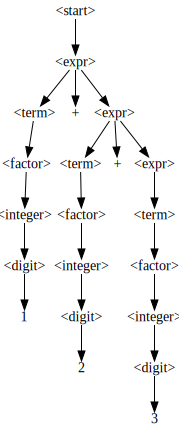

In [49]:
new_grammar = canonical(EXPR_GRAMMAR)
for tree in parse(list('1+2+3'), new_grammar):
    display_tree(tree)

#### Ambiguous grammars

Ambiguous grammars generate parse forests.

In [50]:
grammar= {
        '<start>': ['<A>'],
        '<A>': ['<A>+<A>', 'a'],
        }

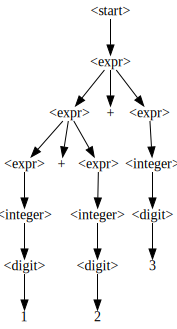

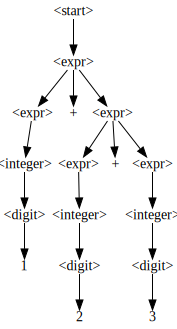

In [51]:
new_grammar = canonical(A1_GRAMMAR)
for tree in parse(list('1+2+3'), new_grammar, '<start>'):
    display_tree(tree)

## Further Information
* Parsing with arbitrary context free grammars is reducible to boolean matrix multiplication~\cite{Valiant1975} (and the reverse~\cite{Lee2002}) which is at present bounded by \Latex{O(2^{23728639}}) ~\cite{LeGall2014}
* The actual class of languages that is expressible in PEG is currently unknown. In particular, we know that PEGs can express certain languages such as \Latex{a^n b^n c^n}. However, we do not know if there exist Context-Free languages that are not expressible with PEGs.

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Exercises

Close the chapter with a few exercises such that people have things to do.  In Jupyter Notebook, use the `exercise2` nbextension to add solutions that can be interactively viewed or hidden:

* Mark the _last_ cell of the exercise (this should be a _text_ cell) as well as _all_ cells of the solution.  (Use the `rubberband` nbextension and use Shift+Drag to mark multiple cells.)
* Click on the `solution` button at the top.

(Alternatively, just copy the exercise and solution cells below with their metadata.)

### Exercise 1

The _PEG_ syntax provides a few notational conveniences reminiscent of regular expressions. For example, it supports the following operators (letters `T` and `A` represents tokens that can be either terminal or non-terminal. `ε` is an empty string, and `/` is the ordered choice operator similar to the non-ordered choice operator `|`):

* `T?` represents an optional greedy match of T and `A := T?` is equivalent to `A := T/ε`.
* `T*` represents zero or more greedy matches of `T` and `A := T*` is equivalent to `A := T A/ε`.
* `T+` represents one or more greedy matches -- equivalent to `TT*`

If you look at the three notations above, each can be represented in the grammar in terms of basic syntax.
Remember the exercise from [the chapter on grammars](Grammars.ipynb) that developed `define_ex_grammar` that can represent grammars as Python code? extend `define_ex_grammar` to `define_peg` to support the above notational conveniences. The decorator should rewrite a given grammar that contain these notations to an equivalent grammar in basic syntax.

In [52]:
pass

### Exercise 2

Beyond these notational conveniences, it also supports two predicates that can provide a powerful lookahead facility that does not consume any input.

* `T&A` represents an _And-predicate_ that matches `T` if `T` is matched, and it is immediately followed by `A`
* `T!A` represents a _Not-predicate_ that matches `T` if `T` is matched, and it is *not* immediately followed by `A`

Implement these predicates in our _PEG_ parser.

_No solution yet_

In [53]:
pass

### Exercise 3

In the `Earley Parser`, `Column` class, we keep the states both as a `list` and also as a `dict` even though `dict` is ordered. Can you explain why?

**Hint**: see the `fill_chart` method.

In [54]:
pass

### Exercise 4

In the `Earley Parser` explanation for `fill_chart` method, we added a marker indicating an epsilon derivation. Can one statically compute such epsilon derivations given a grammar? can one do it exhaustively given any CFG?

In [55]:
pass

### Exercise 5

In `Earley Parser` methods, we kept a list of children for each state. However, if you see `complete`, we computed the parent states directly from a state. Given that we can obtain leaf states directly from the last column, can you extract the parse forest directly without keeping a list of children per state?

In [56]:
RE_NONTERMINAL

re.compile(r'(<[^<> ]*>)', re.UNICODE)

### Exercise 6

The `Earley Parser` as it is implemented, has a computational complexity of $O(n^2)$ for _LR_ grammars. Implement the Leo Joop optimization to make it linear.

In [57]:
class LeoParser(EarleyParser):
    def check_single_item(self, st, remain):
        res = [s for s in remain
                 if s.name == st.name and s.expr == st.expr and
                    s.s_col.i == st.s_col.i and s.dot == (st.dot - 1)]
        return len(res) == 1

    @lru_cache(maxsize=None)
    def get_above(self, state):
        remain, finished = splitlst(lambda s: s.finished(), state.s_col.states)
        vals = [st for st in finished
                    if state.name == st.expr[-1] and
                       self.check_single_item(st, remain)]
        if vals:
            assert len(vals) == 1
            res = self.get_above(vals[0])
            return vals[0] if not res else res
        return None

    def leo_complete(self, col, state):
        detred = self.get_above(state)
        if detred:
            col.add(detred.copy()).children.append(state)
        else:
            self.earley_complete(col, state)

    def complete(self, col, state): return self.leo_complete(col, state)

Note that the above code does not handle epsilons very well. Can you fix it?